### **Configuração do Ambiente**

In [4]:
!pip install geneticalgorithm
!pip install numpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 44 kB 2.9 MB/s 
  Created wheel for func-timeout: filename=func_timeout-4.3.5-py3-none-any.whl size=15098 sha256=ae858e1b3dc783e3f4e39715d8ce880773c59a7a8163aa42f1dfaae439dafd60
  Stored in directory: /root/.cache/pip/wheels/68/b5/a5/67c4364c354e141f5a1bd3ec568126f77877ab7554cf5af8cb
Successfully built func-timeout
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### **Bibliotecas**

In [5]:
import math
import numpy as np
import pandas as pd
import random
import warnings
from geneticalgorithm import geneticalgorithm as ga
from google.colab import drive

warnings.filterwarnings('ignore')
drive.mount("/content/gdrive")

Mounted at /content/gdrive


### **Dados de Histórico de Consumo de Produtos**

In [9]:
itens = pd.read_csv("gdrive/MyDrive/TCC MBA Dani/consumo-pecas.csv")
print("Quantidade de Produtos no Dataframe:", len(itens))
itens.head(10)

Quantidade de Produtos no Dataframe: 5259


,CodigoProduto,202109,202108,202107,202106,202105,202104,202103,202102,202101,...,201706,201705,201704,201703,201702,201701,201612,201611,201610,201609
0,A0000100066,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,A0000100105,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,A00001003010064,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,A0000100333,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,A0000101020,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,A0000101385,2,0,4,1,0,0,2,0,0,...,0,0,0,0,0,0,0,0,0,1
6,A0000101420,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,A0000101585,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,A00001015850064,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,A0000110100,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [23]:
#Mantem apenas os ultimos 12 meses de demanda
itens_12_meses = itens.iloc[:,:13]
itens_12_meses["Consumo-Total"] = itens_12_meses.sum(axis=1)

#Retira os itens com consumo total menor que 70
itens_12_meses = itens_12_meses[itens_12_meses["Consumo-Total"]>70]
itens_12_meses["Consumo-Medio"] = itens_12_meses.iloc[:, :13].mean(axis=1)
itens_12_meses["Desvio-Padrao"] = itens_12_meses.iloc[:, :13].std(axis=1)
print("Quantidade Produtos com Consumo maior que 70 unidades nos ultimos 12 meses:", len(itens_12_meses))
itens_12_meses.head()

Quantidade Produtos com Consumo maior que 70 unidades nos ultimos 12 meses: 107


,CodigoProduto,202109,202108,202107,202106,202105,202104,202103,202102,202101,202012,202011,202010,Consumo-Total,Consumo-Medio,Desvio-Consumo
21,A0000180233,0,6,14,7,23,12,8,24,12,10,9,9,134,11.166667,6.766674
46,A0000789623,44,68,4,8,0,0,0,0,0,0,0,0,124,10.333333,22.071509
50,A0000901551,73,99,92,83,98,86,131,137,108,68,154,79,1208,100.666667,27.056619
80,A0001420289,0,10,15,0,0,28,36,50,13,20,19,6,197,16.416667,15.482884
82,A0001421089,10,20,1,20,1,6,8,2,1,0,0,9,78,6.500000,7.267612


### **Objetivo do Algoritmo**
  Atingir o nível máximo de serviço com menor custo de inventário

### **Função baseada no Modelo Estocástico de Gestão de Inventário**

Esta função irá traduzir os dados de consumo histórico e condições de restrição no formato que pode ser manipulado por um algoritmo genético.

### **Funções para Simulação do Movimento de Inventario**

**Função que distribui os consumos mensais em 360 dias de forma aleatória mas respeitando a demanda mensal a cada mês**

In [24]:
def distribuir_demanda_diaria(consumo):
  demanda_dia = []
  for demanda in consumo:
    for a in range(30):
      valor = random.randint(0, math.ceil(demanda/5))
      demanda -= valor
      demanda_dia.append(valor)
  return demanda_dia

In [35]:
#Abaixo testamos a função criada acima
demanda_historico = np.flip(itens_12_meses.iloc[0:1,1:13].values[0]) # inverte ordem dos meses de consumo 
print(distribuir_demanda_diaria(demanda_historico))

[1, 1, 0, 1, 2, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 2, 2, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 4, 1, 2, 0, 2, 0, 1, 0, 1, 0, 2, 0, 0, 0, 1, 1, 0, 1, 0, 2, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 2, 0, 2, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 1, 1, 0, 0, 2, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 3, 3, 2, 1, 1, 1, 2, 2, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 2, 0, 0, 0, 1, 1, 2, 2, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

**Variáveis de Condições de Restrição e Objetivo de Otimização**

In [36]:
import math
tempo_entrega_max = 6
tempo_entrega_min = 5
service_level = 96 # Percentual de dias nos quais o estoque foi suficiente para cobrir a demanda diaria
imprimir = False
dias_analise = 30

In [ ]:
#Função estocástica para gestão de inventario simulacao__giro_inventario([Estoque Minimo, Lote de Pedido])
def simulacao_giro_inventario(Valores_Simulados): 
    
    imprimir_analise = imprimir
    qt_simulacao = 5
    qt_simulacao_baixo_nivel = 0
    score = 0

    #Para refinar o treinamento e estabilizar a solução prevemos a possibilidade de aumentar o numero de simulações e calcular a média dos scores,
    #no entanto para fins de otimização do tempo de calculo vamos manter em 1 simulação por produto
    for simulacao in range(qt_simulacao):  

        # Cria uma demanda mensal simulada utilizando uma série randomica respeitando o consumo médio e desvio padrão do produto em análise
        demanda_mensal = demanda_historico
        if imprimir_analise:
            print("demanda_mensal", demanda_mensal)
        
        # Faz a distribuição da demanda mensal em dias respeitando os valores gerados para cada mês
        demanda_diaria = distribuir_demanda_diaria(demanda_mensal)
        
        # Salva a quantidade de dias simulados
        total_dias_simulacao = len(demanda_diaria)

        # Inicializa as varíaveis que vão guardar os dados de inventario da simulação
        inventario = [] # lista para armazenar a posição de estoque diário          
        qt_entrada_inventario = [0 for i in range(total_dias_simulacao)]     #Lista vazia que irá armazenar o recebimento de mercadorias para cada dia da simulação
        
        # Guarda as variáveis que serão geradas pelo algorítmo genético
        estoque_minimo = Valores_Simulados[0]
        lote_reposicao = Valores_Simulados[1]

        # inicia a simulação para cada dia dos 12 meses  
        for dia in range(len(demanda_diaria)):
            if dia > dias_analise :
                imprimir_analise = False # limita a impressão da simulação aos dias configurados em dias_analise

            if imprimir_analise:
                print("Simulação Dia", dia + 1)

            if dia == 0:
                # Assume que o primeiro mês terá como estoque o valor do estoque minimo
                estoque_corrente = estoque_minimo            
            else:
                # para os dias seguintes verifica se há pedidos a receber
                estoque_corrente = estoque_corrente + qt_entrada_inventario[dia] 

            if imprimir_analise:
                print("Estoque Inicial:", estoque_corrente)
            demanda = demanda_diaria[dia]   #obtem a demanda do dia simulado
            estoque_corrente = estoque_corrente - demanda

            inventario.append(estoque_corrente)   #Armazena a posição do estoque no final do dia

            if imprimir_analise:
                print("Demanda", demanda)
                print("Estoque Final", estoque_corrente)
           
            #Algoritmo decide com base no estoque minimo selecionado se emitirá uma ordem de compra
            if estoque_corrente < estoque_minimo:
                if dia+tempo_entrega_max < total_dias_simulacao:
                    dias_para_entrega = random.randint(tempo_entrega_min, tempo_entrega_max) #sorteia o tempo de entrega entre o tempo mínimo e o máximo
                    qt_entrada_inventario[dia+dias_para_entrega] =  qt_entrada_inventario[dia+dias_para_entrega]  + lote_reposicao
                    if imprimir_analise:
                        print("Pedido de compra: dia ", dia + 1, " Qt Itens:", lote_reposicao) 
            else:
                if imprimir_analise:
                    print("sem emissão de pedido de compra: dia ", dia + 1)


            if imprimir_analise:
                print("Inventario", inventario)
                print("Entregas Programadas", qt_entrada_inventario)
                print("---")

        #Calcula o score da função com base no nível médio do inventario e no percentual de dias com estoque positivo
        dias_inventario_negativo = len([estoque for estoque in inventario if estoque < 0])
        percentual_dias_estoque_positivo = 1 - (dias_inventario_negativo/total_dias_simulacao)
        
        if (percentual_dias_estoque_positivo < (service_level/100)):
            qt_simulacao_baixo_nivel += 1
        else:
            score = score + np.mean(inventario)
    if qt_simulacao_baixo_nivel > 2:
        score = 10000000
    else:
        score = score/max((qt_simulacao-qt_simulacao_baixo_nivel), 1)
    
    return  score

In [ ]:
# simulacao_giro_inventario([Estoque Minimo, Lote de Pedido])
simulacao_giro_inventario([52, 6]) 

45.9425925925926

### **Execução do Algoritmo Genético com os dados dos Modelo**


Modelo Criado, Procedendo Otimização com o Algoritmo Genético:
Otimizar [Estoque Mínimo, Quantidade por Pedido] & Encontrar menor nível de inventário médio por estratégia

 The best solution found:
 [4. 2.]

 Objective function:
 6.805555555555556


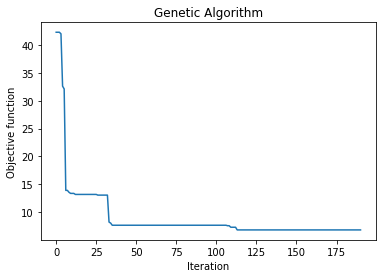


 The best solution found:
 [ 1. 11.]

 Objective function:
 10.29375


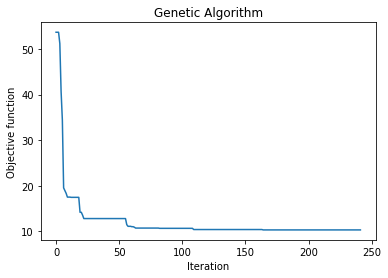


 The best solution found:
 [65.  4.]

 Objective function:
 39.58796296296297


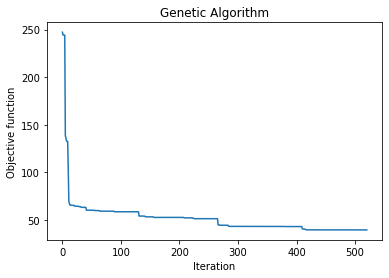


 The best solution found:
 [13.  2.]

 Objective function:
 14.575000000000001


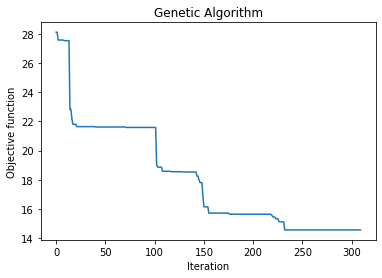


 The best solution found:
 [2. 3.]

 Objective function:
 8.575000000000001


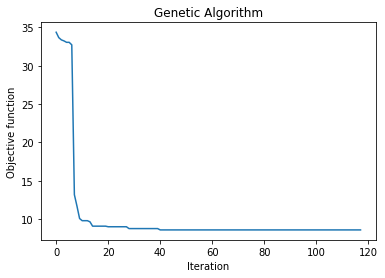


 The best solution found:
 [9. 2.]

 Objective function:
 10.593333333333332


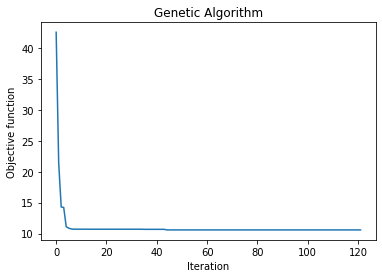


 The best solution found:
 [19.  8.]

 Objective function:
 31.796296296296294


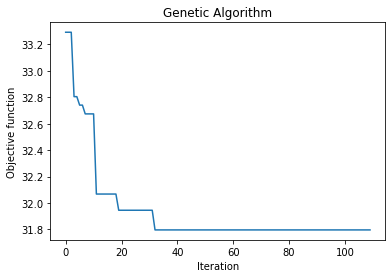


 The best solution found:
 [4. 3.]

 Objective function:
 7.07


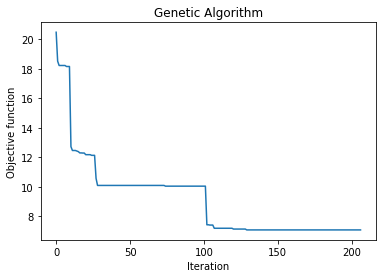


 The best solution found:
 [28. 11.]

 Objective function:
 44.06481481481482


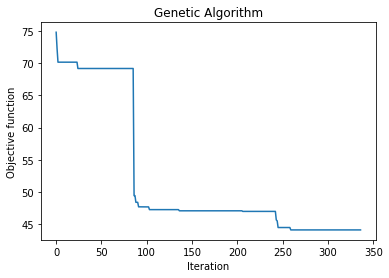


 The best solution found:
 [15.  1.]

 Objective function:
 11.73611111111111


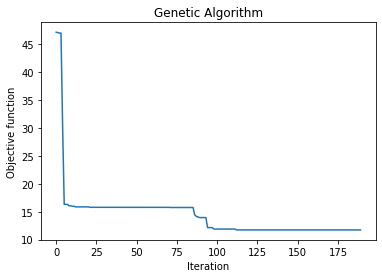


 The best solution found:
 [3. 4.]

 Objective function:
 11.710185185185184


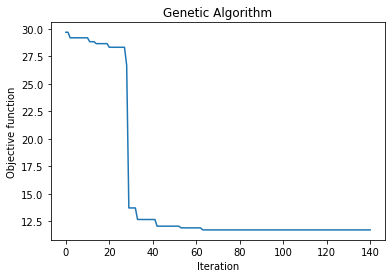


 The best solution found:
 [19.  3.]

 Objective function:
 22.05


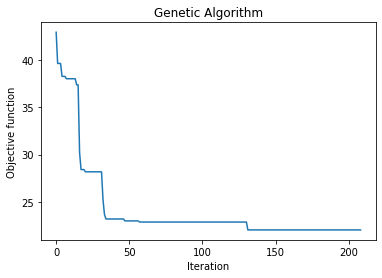


 The best solution found:
 [14.  4.]

 Objective function:
 17.347222222222218


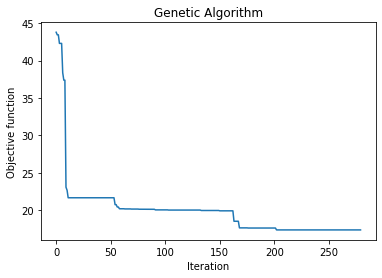


 The best solution found:
 [10.  6.]

 Objective function:
 20.34537037037037


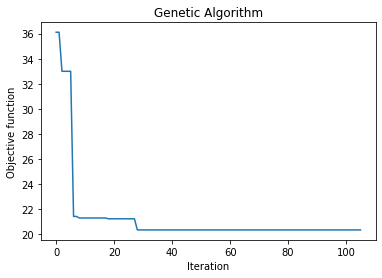


 The best solution found:
 [13.  3.]

 Objective function:
 15.860185185185186


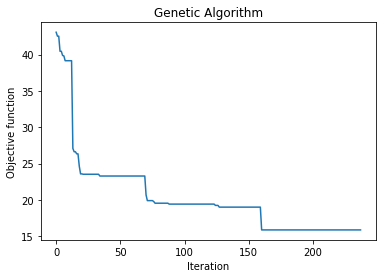


 The best solution found:
 [19.  5.]

 Objective function:
 24.64537037037037


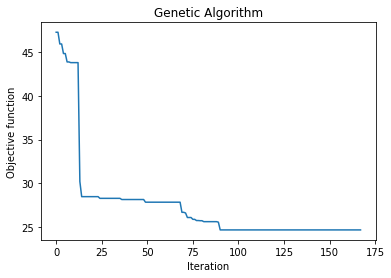


 The best solution found:
 [8. 1.]

 Objective function:
 8.023148148148149


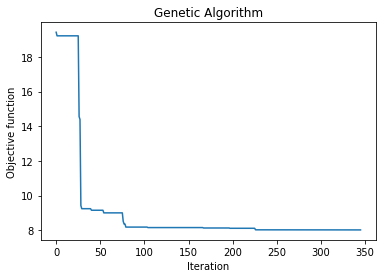


 The best solution found:
 [6. 4.]

 Objective function:
 10.273611111111112


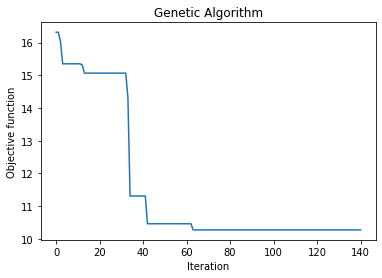


 The best solution found:
 [7. 2.]

 Objective function:
 10.392777777777777


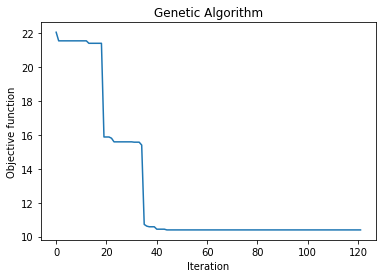


 The best solution found:
 [7. 3.]

 Objective function:
 11.216666666666667


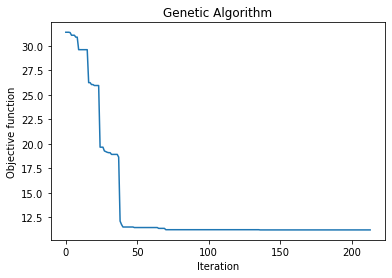


 The best solution found:
 [42.  5.]

 Objective function:
 39.99166666666667


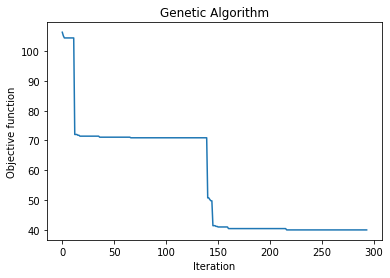


 The best solution found:
 [12.  5.]

 Objective function:
 14.863888888888889


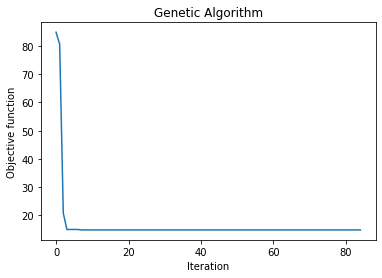


 The best solution found:
 [4. 2.]

 Objective function:
 7.351666666666667


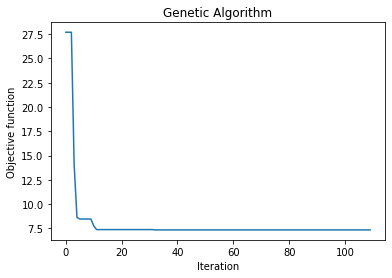


 The best solution found:
 [3. 3.]

 Objective function:
 7.851851851851852


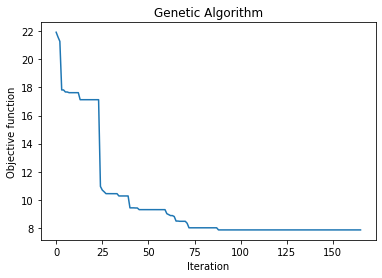


 The best solution found:
 [6. 9.]

 Objective function:
 23.1875


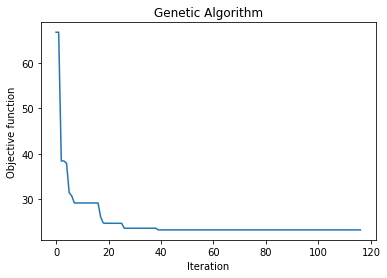


 The best solution found:
 [21.  6.]

 Objective function:
 30.32037037037037


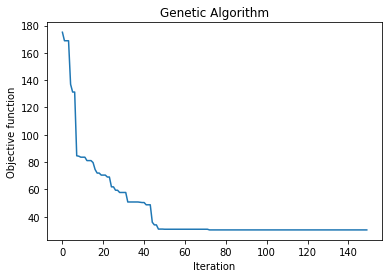


 The best solution found:
 [4. 2.]

 Objective function:
 7.293055555555555


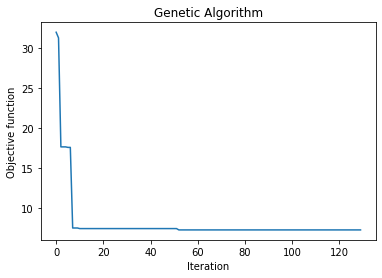


 The best solution found:
 [2. 8.]

 Objective function:
 12.105


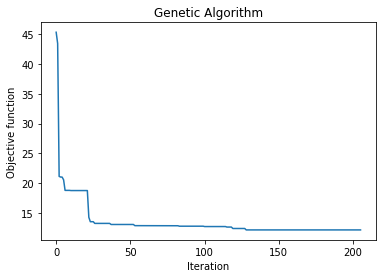


 The best solution found:
 [4. 1.]

 Objective function:
 5.0851851851851855


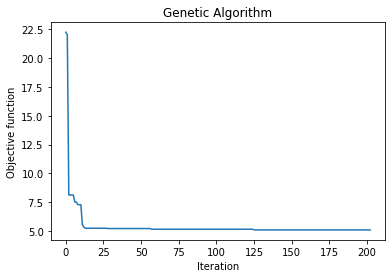


 The best solution found:
 [3. 2.]

 Objective function:
 6.389814814814815


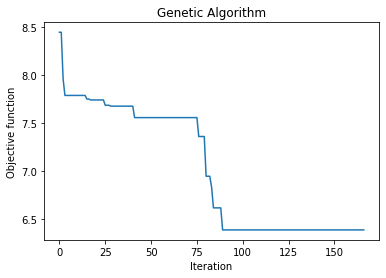


 The best solution found:
 [14. 13.]

 Objective function:
 37.458333333333336


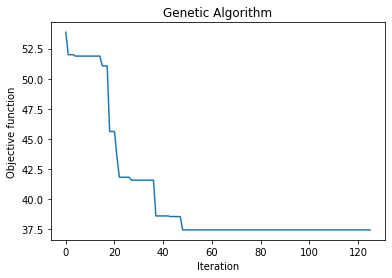


 The best solution found:
 [59.  2.]

 Objective function:
 42.96111111111111


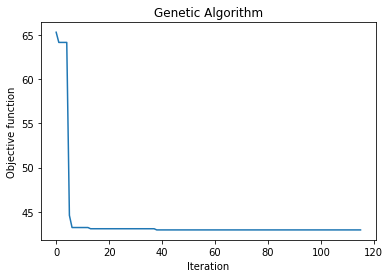


 The best solution found:
 [5. 1.]

 Objective function:
 5.37037037037037


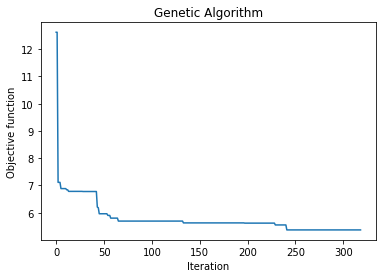


 The best solution found:
 [103.  11.]

 Objective function:
 99.22685185185185


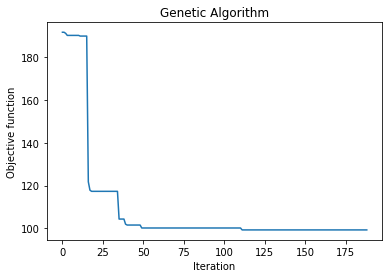


 The best solution found:
 [6. 2.]

 Objective function:
 10.067361111111111


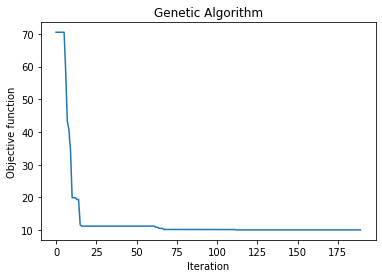


 The best solution found:
 [13.  2.]

 Objective function:
 13.467592592592593


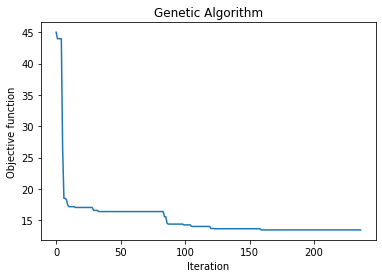


 The best solution found:
 [9. 7.]

 Objective function:
 20.62777777777778


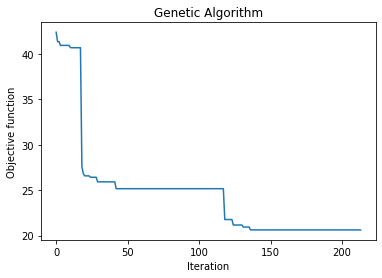


 The best solution found:
 [ 1. 10.]

 Objective function:
 7.902222222222223


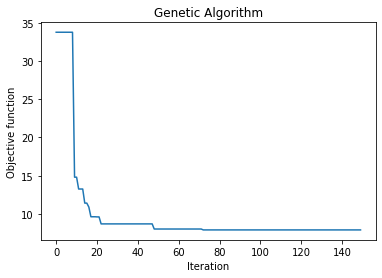


 The best solution found:
 [16.  5.]

 Objective function:
 24.319444444444446


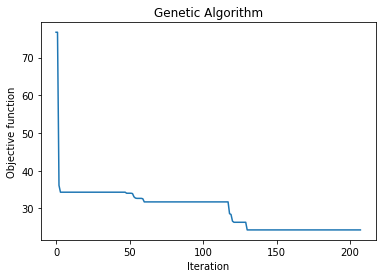


 The best solution found:
 [5. 1.]

 Objective function:
 5.753472222222221


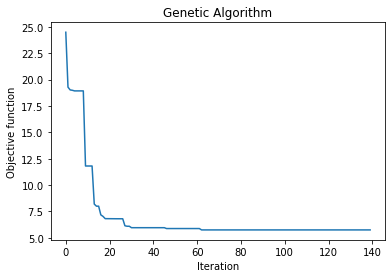


 The best solution found:
 [2. 3.]

 Objective function:
 8.210185185185184


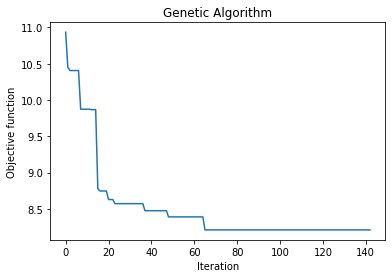


 The best solution found:
 [2. 1.]

 Objective function:
 3.5879629629629632


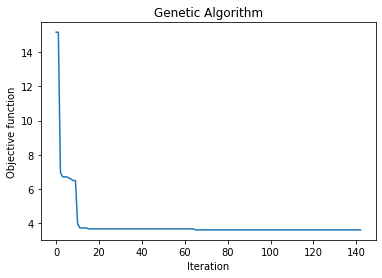


 The best solution found:
 [9. 6.]

 Objective function:
 21.26888888888889


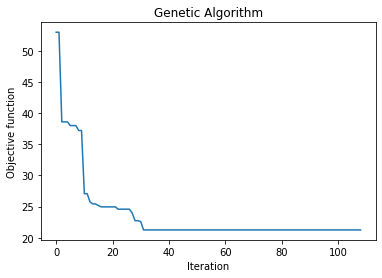


 The best solution found:
 [6. 2.]

 Objective function:
 8.946111111111112


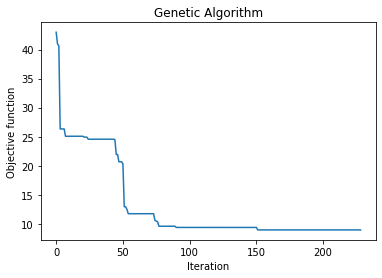


 The best solution found:
 [12.  8.]

 Objective function:
 21.764814814814816


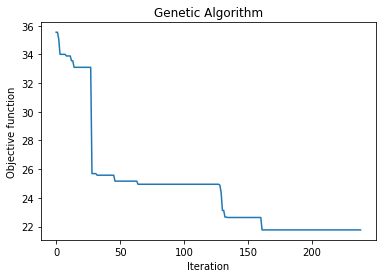


 The best solution found:
 [6. 4.]

 Objective function:
 13.012962962962964


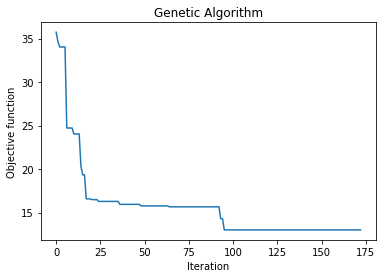


 The best solution found:
 [3. 3.]

 Objective function:
 8.343518518518517


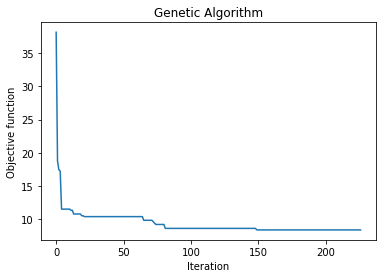


 The best solution found:
 [7. 2.]

 Objective function:
 9.37361111111111


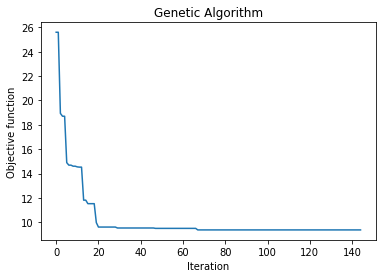


 The best solution found:
 [7. 2.]

 Objective function:
 9.410185185185185


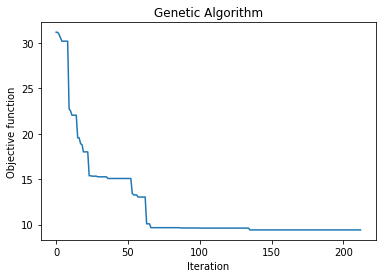


 The best solution found:
 [15.  9.]

 Objective function:
 30.168055555555554


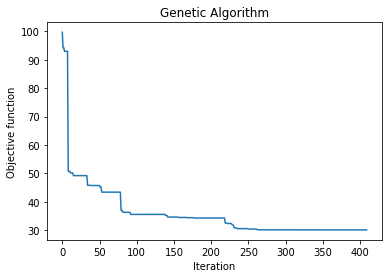


 The best solution found:
 [18.  5.]

 Objective function:
 23.055555555555554


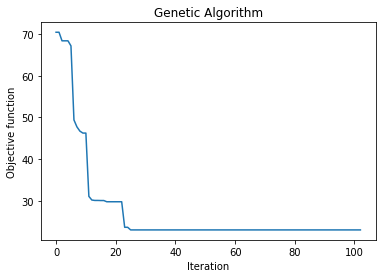


 The best solution found:
 [33.  9.]

 Objective function:
 41.81388888888889


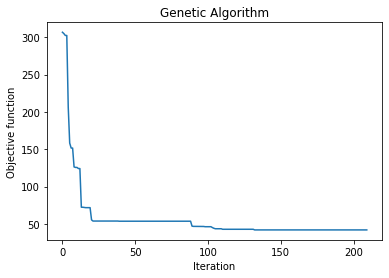


 The best solution found:
 [3. 2.]

 Objective function:
 6.469444444444445


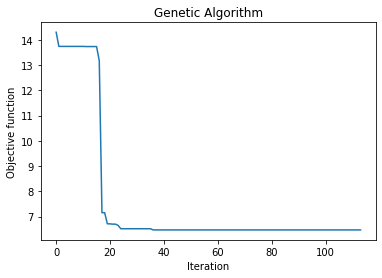


 The best solution found:
 [18.  2.]

 Objective function:
 16.29074074074074


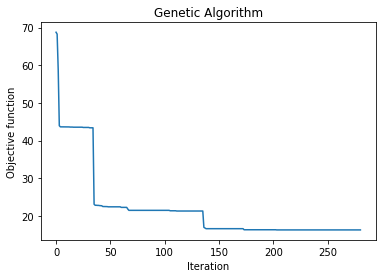


 The best solution found:
 [6. 6.]

 Objective function:
 17.564814814814813


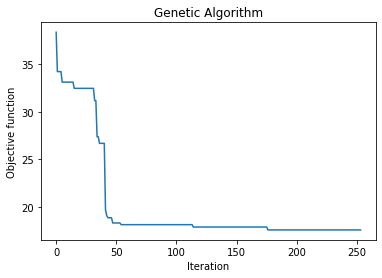


 The best solution found:
 [9. 4.]

 Objective function:
 15.139814814814814


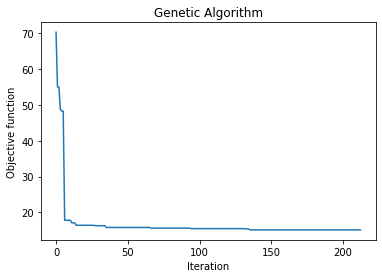


 The best solution found:
 [31.  4.]

 Objective function:
 29.489814814814817


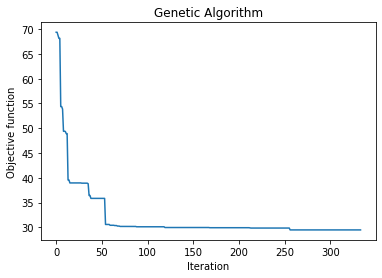


 The best solution found:
 [30.  4.]

 Objective function:
 27.45648148148148


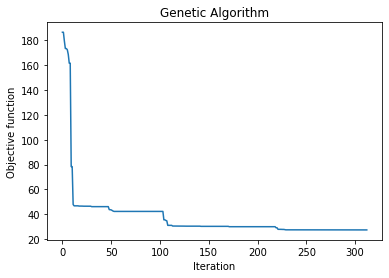


 The best solution found:
 [4. 2.]

 Objective function:
 7.027777777777778


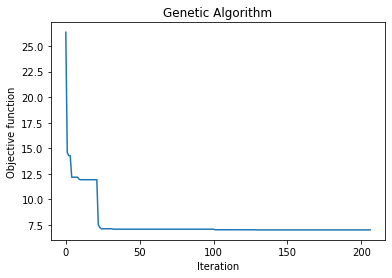


 The best solution found:
 [15.  2.]

 Objective function:
 12.987037037037036


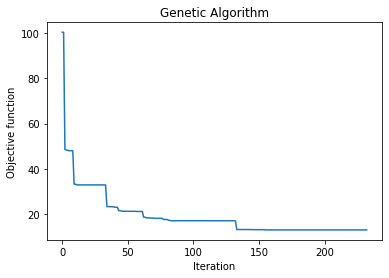


 The best solution found:
 [5. 2.]

 Objective function:
 7.9259259259259265


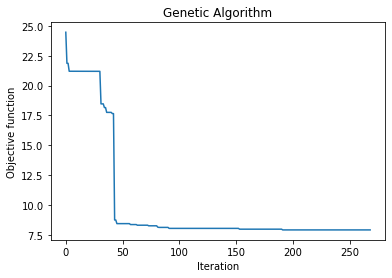


 The best solution found:
 [6. 2.]

 Objective function:
 8.91388888888889


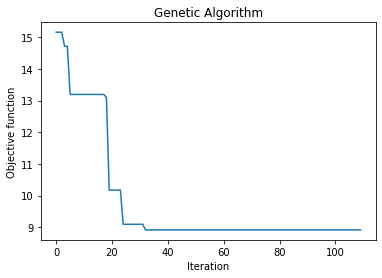


 The best solution found:
 [20.  2.]

 Objective function:
 21.18472222222222


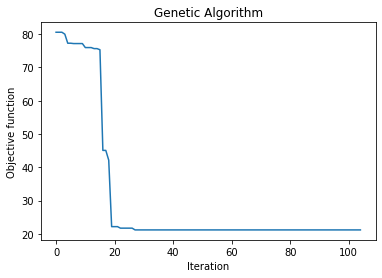


 The best solution found:
 [9. 7.]

 Objective function:
 21.325694444444448


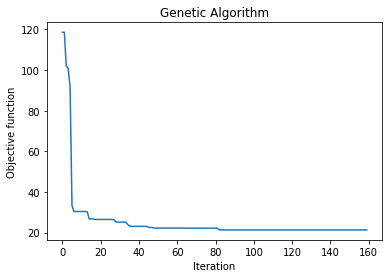


 The best solution found:
 [4. 2.]

 Objective function:
 6.339583333333334


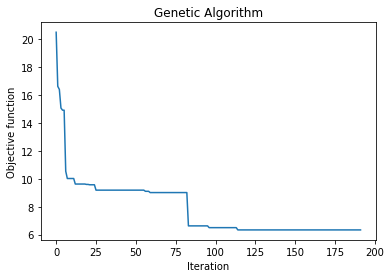


 The best solution found:
 [3. 3.]

 Objective function:
 8.287962962962963


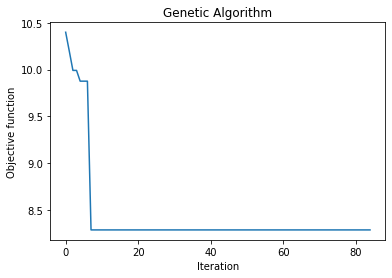


 The best solution found:
 [4. 1.]

 Objective function:
 4.632407407407407


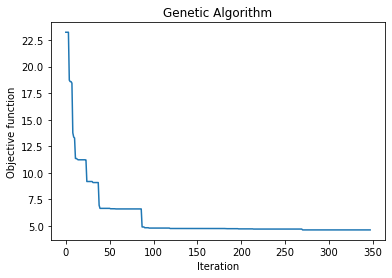


 The best solution found:
 [4. 1.]

 Objective function:
 5.058333333333333


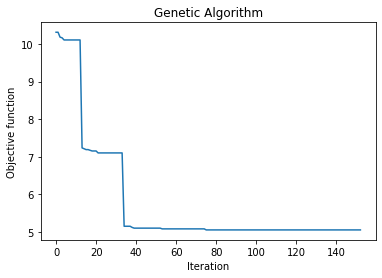


 The best solution found:
 [5. 9.]

 Objective function:
 16.673333333333336


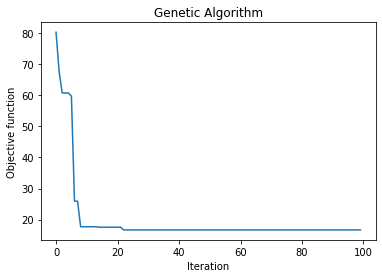


 The best solution found:
 [14.  2.]

 Objective function:
 15.795370370370371


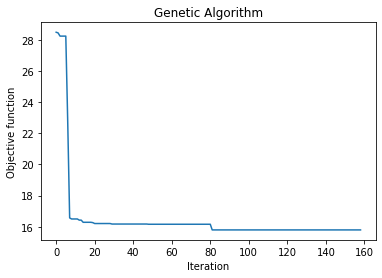


 The best solution found:
 [10.  1.]

 Objective function:
 9.775


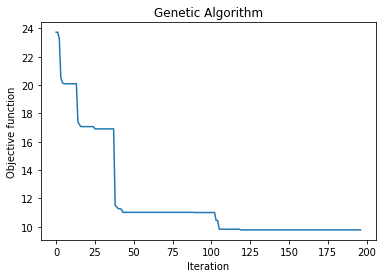


 The best solution found:
 [ 6. 17.]

 Objective function:
 33.41018518518519


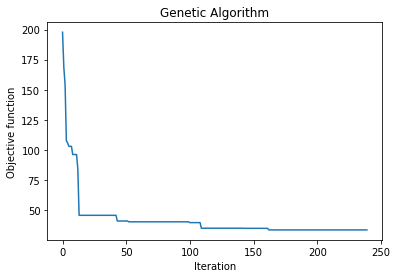


 The best solution found:
 [7. 4.]

 Objective function:
 7.231111111111112


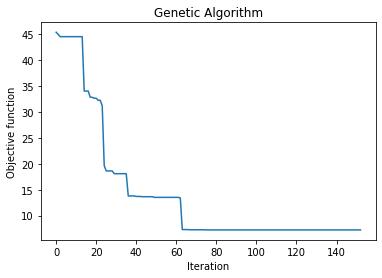


 The best solution found:
 [7. 3.]

 Objective function:
 11.723611111111111


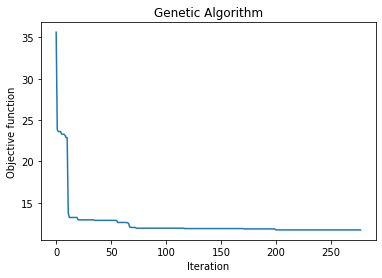


 The best solution found:
 [22.  2.]

 Objective function:
 21.287037037037035


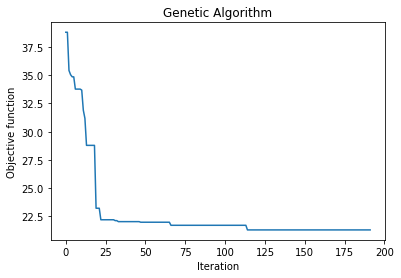


 The best solution found:
 [4. 6.]

 Objective function:
 14.390555555555556


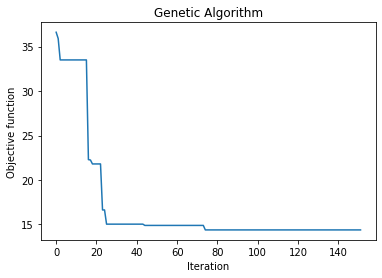


 The best solution found:
 [7. 2.]

 Objective function:
 9.196527777777778


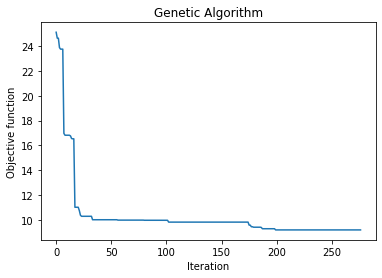


 The best solution found:
 [4. 4.]

 Objective function:
 12.075925925925928


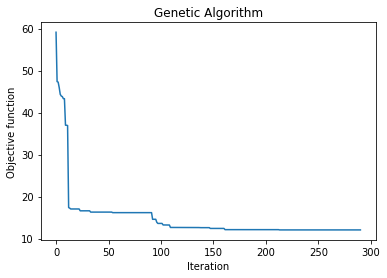


 The best solution found:
 [9. 8.]

 Objective function:
 12.60462962962963


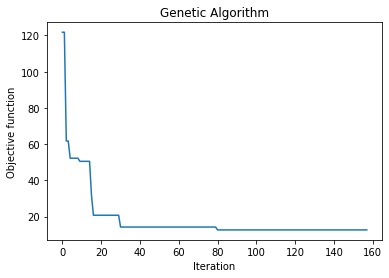


 The best solution found:
 [25. 10.]

 Objective function:
 38.47944444444444


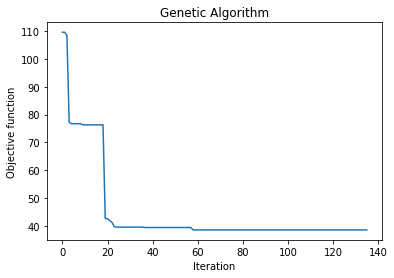


 The best solution found:
 [8. 1.]

 Objective function:
 8.123148148148148


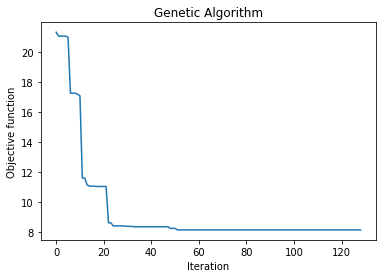


 The best solution found:
 [3. 2.]

 Objective function:
 5.7451388888888895


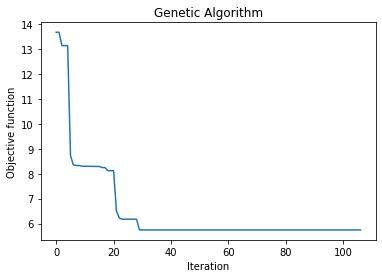


 The best solution found:
 [7. 1.]

 Objective function:
 6.932407407407407


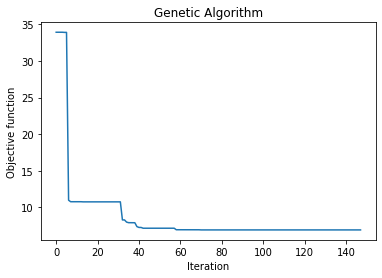


 The best solution found:
 [5. 2.]

 Objective function:
 7.518518518518518


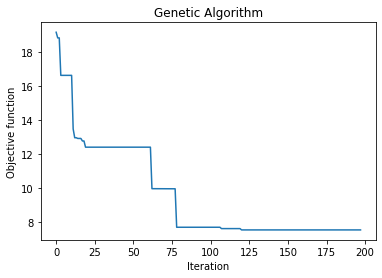


 The best solution found:
 [28.  2.]

 Objective function:
 23.244999999999997


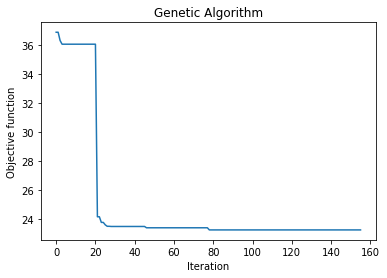


 The best solution found:
 [5. 1.]

 Objective function:
 5.794444444444444


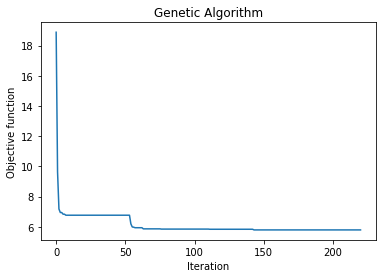


 The best solution found:
 [5. 2.]

 Objective function:
 7.647222222222222


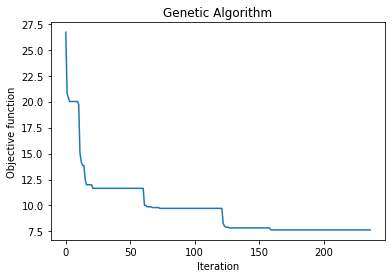


 The best solution found:
 [4. 1.]

 Objective function:
 5.32037037037037


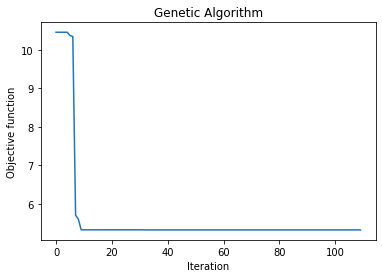


 The best solution found:
 [7. 2.]

 Objective function:
 9.865277777777777


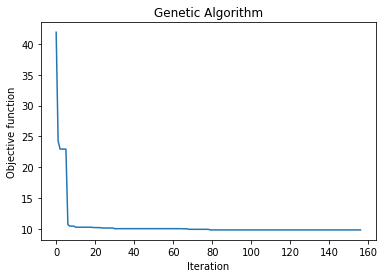


 The best solution found:
 [50.  2.]

 Objective function:
 34.64814814814815


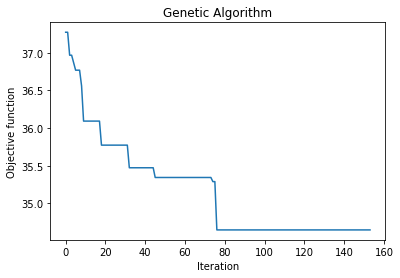


 The best solution found:
 [14.  1.]

 Objective function:
 12.448611111111113


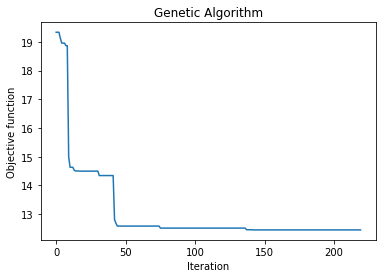


 The best solution found:
 [29. 12.]

 Objective function:
 48.02152777777778


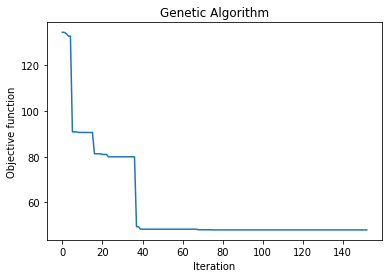


 The best solution found:
 [5. 3.]

 Objective function:
 10.7625


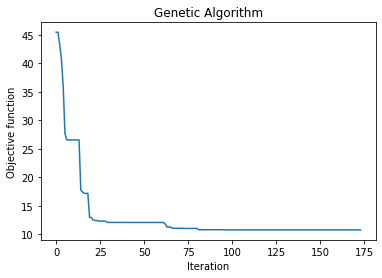


 The best solution found:
 [3. 2.]

 Objective function:
 6.770138888888889


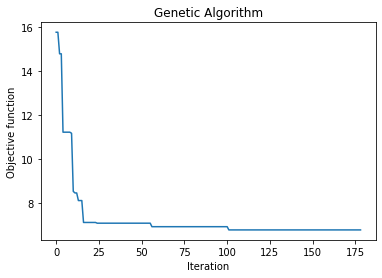


 The best solution found:
 [9. 1.]

 Objective function:
 8.648888888888889


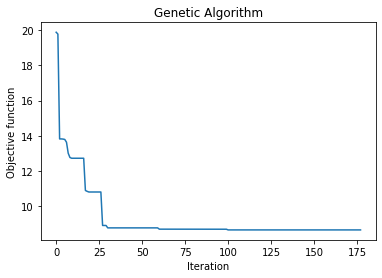


 The best solution found:
 [19.  1.]

 Objective function:
 13.727777777777776


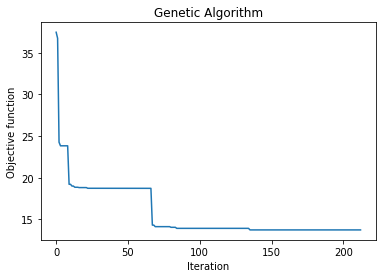


 The best solution found:
 [8. 1.]

 Objective function:
 7.6201388888888895


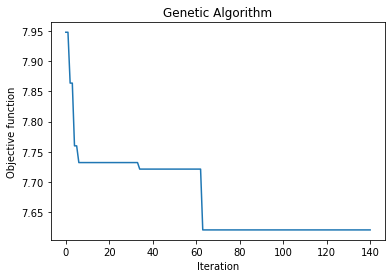


 The best solution found:
 [15. 12.]

 Objective function:
 36.150925925925925


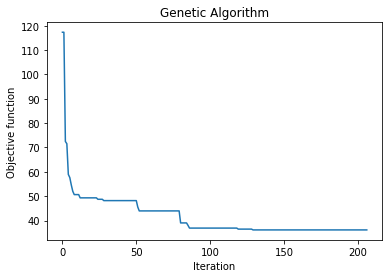


 The best solution found:
 [2. 5.]

 Objective function:
 10.503888888888888


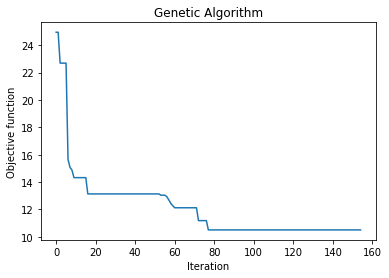


 The best solution found:
 [19.  2.]

 Objective function:
 17.227777777777778


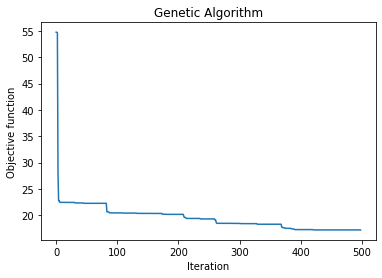


 The best solution found:
 [9. 2.]

 Objective function:
 10.927083333333334


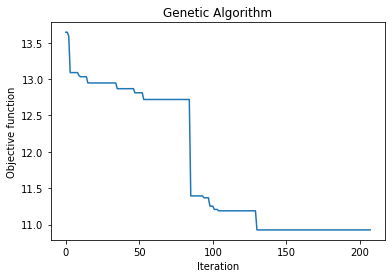


 The best solution found:
 [18.  2.]

 Objective function:
 16.009027777777778


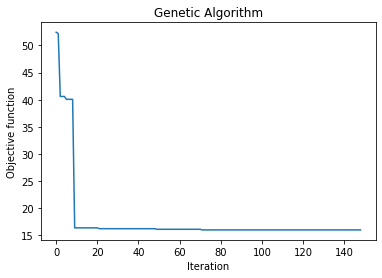


 The best solution found:
 [15.  4.]

 Objective function:
 19.014444444444443


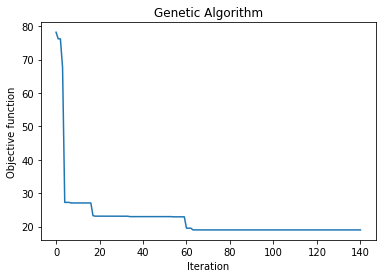


 The best solution found:
 [4. 3.]

 Objective function:
 10.399305555555555


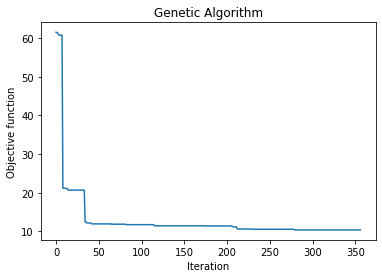


 The best solution found:
 [3. 4.]

 Objective function:
 10.462037037037037


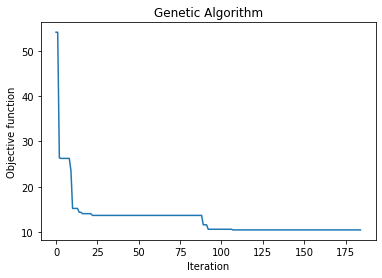


 The best solution found:
 [47.  2.]

 Objective function:
 26.06851851851852


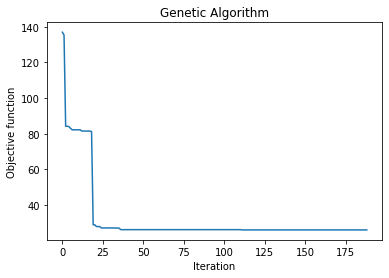


 The best solution found:
 [16.  5.]

 Objective function:
 22.185185185185187


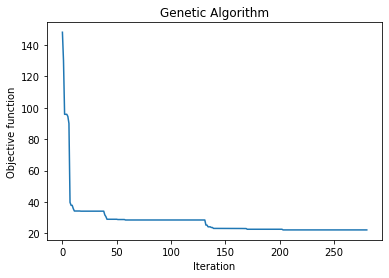

In [ ]:
print()
print("Modelo Criado, Procedendo Otimização com o Algoritmo Genético:")
print("Otimizar [Estoque Mínimo, Quantidade por Pedido] & Encontrar menor nível de inventário médio por estratégia")
print()
parametros_algoritmo_genetico = {'max_num_iteration': 1000,
                   'population_size':8,
                   'mutation_probability':0.1,
                   'elit_ratio': 0.01,
                   'crossover_probability': 0.5,
                   'parents_portion': 0.3,
                   'crossover_type':'uniform',
                   'max_iteration_without_improv':75}

predicoes = []
for linha in range(len(itens_12_meses)):

    # Obtem dados de cada produto
    demanda_historico = np.flip(itens_12_meses.iloc[linha+0:linha+1,1:13].values[0]) # inverte ordem dos meses de consumo do antigo para o mais novo 
    
    # Abaixo os parâmetros utilizados para treino e execução do Algoritmo Genético
    dominio_valores_de_teste=np.array([[1,demanda_historico.max()*2],[1,demanda_historico.max()]])

    # Executa o modelo para cada produto do dataframe selecionado
    model=ga(function=simulacao_giro_inventario,dimension=2,variable_type='int',variable_boundaries=dominio_valores_de_teste,algorithm_parameters=parametros_algoritmo_genetico)
    model.run()    
    predicoes.append([ itens_12_meses.iloc[linha,0], model.best_variable[0], model.best_variable[1], model.best_function])


In [ ]:
# imprime resultados por produto e gera arquivo CSV com os dados gerados pelo Algoritmo Genetico
pd.set_option('display.max_rows', 500)
analise_algoritmo = pd.DataFrame(data=predicoes, columns=[["Codigo Produto", "Estoque Minimo", "Lote por Pedido", "Estoque-Medio-Projetado"]])
analise_algoritmo = analise_algoritmo.round()
analise_algoritmo.to_csv("gdrive/MyDrive/TCC MBA Dani/consumo-gerado-pelo-algoritmo-genetico.csv")
analise_algoritmo

,Codigo Produto,Estoque Minimo,Lote por Pedido,Estoque-Medio-Projetado
0,A0000180233,4.0,2.0,7.0
1,A0000789623,1.0,11.0,10.0
2,A0000901551,65.0,4.0,40.0
3,A0001420289,13.0,2.0,15.0
4,A0001421089,2.0,3.0,9.0
5,A0001806409,9.0,2.0,11.0
6,A0001808109,19.0,8.0,32.0
7,A0002011080,4.0,3.0,7.0
8,A0002703698,28.0,11.0,44.0
9,A0003531273,15.0,1.0,12.0
